In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 20.3 MB/s 
     |████████████████████████████████| 1.8 MB 18.8 MB/s 
     |████████████████████████████████| 374 kB 21.6 MB/s 
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
    Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import random
import numpy as np
import gym
import imageio  # write env render to mp4
import datetime
from collections import deque
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.optimizers import Adam
import torch.nn.functional as F
import torch.autograd as autograd
 
import cv2
import torch as T
import torch.nn as nn
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage , AnnotationBbox

import torch.nn.functional as F
import os


In [ ]:
def plot_learning_curves(num_episodes, epsilon_value = 1.0 , min_epsilon = 0.01, decay_rate = 0,lines = None, string = None):
  epsilon_val = []
  plt.figure(figsize=(15, 10))
  decay_rate = (min_epsilon / epsilon_value) ** (1/num_episodes)
  while epsilon_value >= min_epsilon:
      epsilon_value *= decay_rate
      epsilon_val.append(epsilon_value) 
  print(epsilon_val)            
  plt.figure(figsize=(15, 10))
  plt.plot(epsilon_val, linewidth=4)
  plt.xlabel('Episode', fontsize=28)
  plt.ylabel('Epsilon Values', fontsize=28)
  plt.title(string, fontsize=36)
  plt.xticks(fontsize=24)
  plt.yticks(fontsize=24)
  plt.ylim(ymin=0, ymax=1)
  plt.xlim(xmin=0, xmax=num_episodes)
  plt.grid()
  plt.show()

In [ ]:
def plot_learning(scores, x=None, window = 5, string = None):

  plt.figure(figsize=(15, 10))
  N = len(scores)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = np.mean(scores[max(0,t-window):(t+1)])
  if x is None:
    x = [i for i in range(N)]
  plt.ylabel("Score")
  plt.xlabel("Episode")
  plt.title(string)
  plt.plot(x,running_avg)

In [ ]:
class Experience_replay_buffer():
  def __init__(self, max_size, input_dim, output_dim):

    self.experience_mem_size = max_size
    self.experience_replay_counter = 0 
    self.experience_replay_memory = deque(maxlen=self.experience_mem_size)
    

  def transitions_memory(self, state, action, rewards, new_state, done): #storing elements in appropriate arrays 
    self.experience_replay_memory.append([state, action, rewards, new_state, done])

    self.experience_replay_counter += 1

  def random_choice_function(self, batch_size):
    

    max_memory = min(self.experience_replay_counter, self.experience_mem_size) 

    # if len(self.experience_replay_memory) < batch_size:
            # return 0
    
    # batch = np.random.choice(self.experience_replay_memory, batch_size) #select memories for sampling from buffer
    batch = random.sample(list(self.experience_replay_memory), batch_size)
    states, action, reward, new_states, done = map(np.asarray, zip(*batch))

    return states, action, reward, new_states, done

In [ ]:

class DuelingDQAgent():

  
  def __init__(self, discount_factor, epsilon, learning_rate, input_dims, output_dims, memory_size, batch_size, epsilon_min = 0.01, epsilon_decay = 0.995, replace_every = 5000):

    self.discount_factor = discount_factor
    self.epsilon = epsilon
    self.learning_rate = learning_rate
    self.input_dims = input_dims
    self.output_dims = output_dims
    self.memory_size = memory_size
    self.batch_size = batch_size
    self.epsilon_min = epsilon_min
    self.epsilon_decay = epsilon_decay 
    self.replace_every = replace_every

    self.action_space = [i for i in range(self.output_dims)]

    self.replay_memory = Experience_replay_buffer(memory_size, input_dims, output_dims)

    self.q_values =  DuelingDeepQNetwork(self.learning_rate, self.output_dims, input_dims = self.input_dims)
    self.target_q_value = DuelingDeepQNetwork(self.learning_rate, self.output_dims, input_dims = self.input_dims)
    self.learned_step_counter = 0

  
  
  
  
  
  
  
  
  
  
  
  def act(self, observation):
    if np.random.random() == self.epsilon:
      state = T.tensor([observation], dtype = T.float)
      _ , q_value = self.q_values.forward(state)
      action = T.argmax(q_value).item()

    else:
      action = np.random.choice(self.action_space)

    return action

  
  
  
  
  
  
  
  def store_transitions_for_experience_replay(self, state, action, reward, next_state, done):
    self.replay_memory.transitions_memory(state, action, reward, next_state, done)

  
  
  
  
  
  
  
  def replace_weights_of_target_network(self):
    if self.learned_step_counter % self.replace_every == 0:
      self.target_q_value.load_state_dict(self.q_values.state_dict())

  
  
  
  
  
  
  def decrement_epsilon_decay(self):
    self.epsilon = self.epsilon - self.epsilon_decay  if self.epsilon > self.epsilon_min else self.epsilon_min

  
  
  
  
  
  
  
  
  
  def train(self): 
    if self.replay_memory.experience_replay_counter < self.batch_size:
      return

    self.q_values.optimizer.zero_grad()

    
    # print("yolo"*10,self.replay_memory.experience_replay_memory)



    self.replace_weights_of_target_network()
    state, action, reward, new_state, done = self.replay_memory.random_choice_function(self.batch_size)  


    states = T.tensor(state)
    action = T.tensor(action)
    done = T.tensor(done)
    rewards = T.tensor(reward)
    new_states = T.tensor(new_state)
    
    
    

    q_value_state, action_state = self.q_values.forward(states)
    
    new_q_value_state, new_action_state = self.target_q_value.forward(new_states)
  

    evaluated_q_value_state, evaluated_action_state = self.q_values.forward(new_states)


    predicted_q_values = T.tensor(q_value_state,dtype=T.float32,requires_grad=True)
    next_q_value = T.tensor(new_q_value_state,dtype=T.float32,requires_grad=True)
    evaluated_q_values = T.tensor(evaluated_q_value_state,dtype=T.float32,requires_grad=True)

    


    #finding max action of next states according to the evaluation network

    max_actions = T.argmax(evaluated_q_values, dim = 1)

    # tackling evaluation of rewards if the next state is terminal
    # next_q_value[done] = 0.0

    # print("%%%%%\n"*50,q_target.shape)
    # print("^^^^^\n"*50,q_target.shape)
    # print("Rewards = %%%%%\n"*50,rewards)
    # print("next-Q.    %%%%%\n"*50,next_q_value)
    q_target = rewards + self.discount_factor * next_q_value[max_actions] # get discounted reward
    # q_target.requires_grad_()
    q_target = T.tensor(q_target,dtype=T.float32,requires_grad=True)
    predicted_q_values =T.tensor(predicted_q_values,dtype=T.float32,requires_grad=True)
    

    loss = self.q_values.loss_function(q_target , predicted_q_values)
    loss.backward()
    self.q_values.optimizer.step()
    
    self.learned_step_counter += 1
    if self.learned_step_counter % self.replace_every == 0: 
      self.learned_step_counter = 0 
      # self.target_q_value.load_state_dict(self.q.state_dict())
      agent.replace_weights_of_target_network()

      

      
    
    self.decrement_epsilon_decay()
    
    
    # self.target_q_value.late



In [ ]:
class DuelingDeepQNetwork(nn.Module):

  def __init__(self, learning_rate, output_dims, input_dims):

    super(DuelingDeepQNetwork, self).__init__()
    self.learning_rate = learning_rate
    self.output_dims = output_dims
    self.input_dims = input_dims
    self.fully_connected_1 = nn.Linear(input_dims, 64)
    self.hidden_layer = nn.Linear(64,1)
    self.terminal_layer = nn.Linear(64, output_dims)

    self.optimizer = T.optim.Adam(self.parameters(), lr = self.learning_rate)
    self.loss_function = nn.MSELoss()

  def forward(self,state):
      flattened_1 = F.relu(self.fully_connected_1(state))
      hidden_layer = self.hidden_layer(flattened_1)
      terminal_layer = self.terminal_layer(flattened_1)

      return hidden_layer, terminal_layer


In [ ]:
env = gym.make('CartPole-v1')

input_dims = env.observation_space.shape[0]
output_dims = env.action_space.n

num_episodes = 20

agent = DuelingDQAgent(discount_factor = 0.99, epsilon = 1.0, learning_rate = 5e-4, input_dims = input_dims, output_dims = output_dims, memory_size = 100, batch_size = 64, epsilon_min = 0.01,  epsilon_decay = 0.995, replace_every = 100)

scores, epsilon_history = [] , []


for i in range(num_episodes):
  done = False
  observation = env.reset()
  score = 0

  while not done:
    action = agent.act(observation)
    next_observation, reward, done, info = env.step(action)
    score  += reward
    agent.store_transitions_for_experience_replay(observation, action, reward, next_observation, int(done))
    agent.train()
    observation = next_observation
    
  scores.append(score)
  average_score = np.mean(scores[-100:])

  print('Episode:', i, 'score %.1f' % score, 'average score %.1f' % average_score, 'epsilon %.2f' % agent.epsilon)


  epsilon_history.append(agent.epsilon)
  






/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-7-6fdb41a73990>:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_q_values = T.tensor(q_value_state,dtype=T.float32,requires_grad=True)
<ipython-input-7-6fdb41a73990>:119: UserWarning: To copy construct from a tensor, it i

Episode: 0 score 15.0 average score 15.0 epsilon 1.00
Episode: 1 score 22.0 average score 18.5 epsilon 1.00
Episode: 2 score 10.0 average score 15.7 epsilon 1.00
Episode: 3 score 19.0 average score 16.5 epsilon 0.01
Episode: 4 score 10.0 average score 15.2 epsilon 0.01
Episode: 5 score 12.0 average score 14.7 epsilon 0.01
Episode: 6 score 15.0 average score 14.7 epsilon 0.01
Episode: 7 score 15.0 average score 14.8 epsilon 0.01
Episode: 8 score 13.0 average score 14.6 epsilon 0.01
Episode: 9 score 11.0 average score 14.2 epsilon 0.01
Episode: 10 score 15.0 average score 14.3 epsilon 0.01
Episode: 11 score 18.0 average score 14.6 epsilon 0.01
Episode: 12 score 19.0 average score 14.9 epsilon 0.01
Episode: 13 score 18.0 average score 15.1 epsilon 0.01
Episode: 14 score 37.0 average score 16.6 epsilon 0.01
Episode: 15 score 22.0 average score 16.9 epsilon 0.01
Episode: 16 score 23.0 average score 17.3 epsilon 0.01
Episode: 17 score 23.0 average score 17.6 epsilon 0.01
Episode: 18 score 14

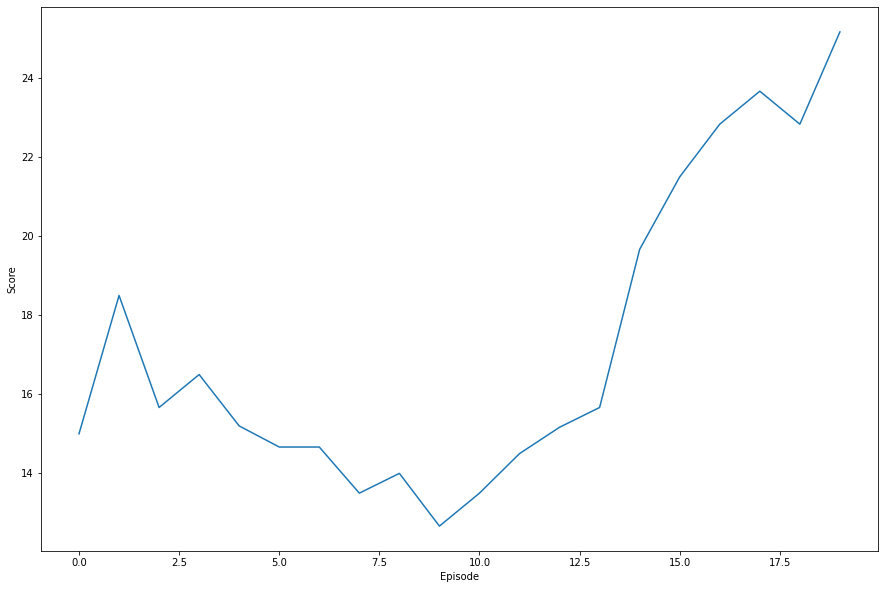

In [ ]:
plot_learning(scores = scores)

[0.7943282347242815, 0.6309573444801932, 0.5011872336272722, 0.3981071705534972, 0.3162277660168379, 0.25118864315095796, 0.19952623149688792, 0.15848931924611132, 0.1258925411794167, 0.09999999999999998, 0.07943282347242814, 0.06309573444801932, 0.05011872336272722, 0.03981071705534972, 0.03162277660168379, 0.025118864315095798, 0.019952623149688792, 0.01584893192461113, 0.012589254117941668, 0.009999999999999997]


<Figure size 1080x720 with 0 Axes>

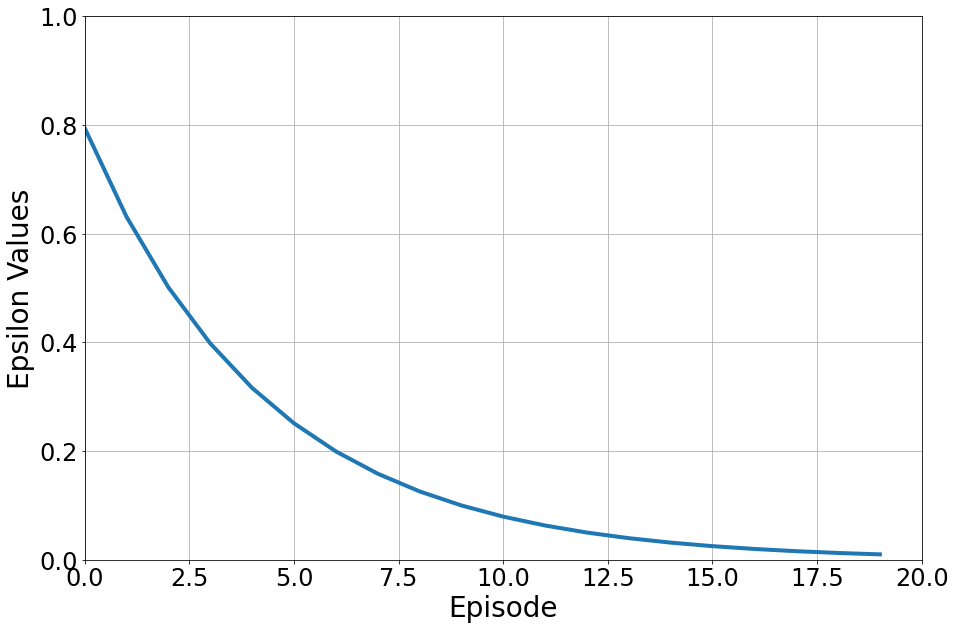

In [ ]:
plot_learning_curves(num_episodes = 20)

In [ ]:
#################################################################################################################

In [ ]:
env = gym.make('LunarLander-v2')

input_dims = env.observation_space.shape[0]
output_dims = env.action_space.n

num_episodes = 20

agent = DuelingDQAgent(discount_factor = 0.99, epsilon = 1.0, learning_rate = 5e-4, input_dims = input_dims, output_dims = output_dims, memory_size = 100, batch_size = 64, epsilon_min = 0.01,  epsilon_decay = 0.995, replace_every = 100)

scores, epsilon_history = [] , []


for i in range(num_episodes):
  done = False
  observation = env.reset()
  score = 0

  while not done:
    action = agent.act(observation)
    next_observation, reward, done, info = env.step(action)
    score  += reward
    agent.store_transitions_for_experience_replay(observation, action, reward, next_observation, int(done))
    agent.train()
    observation = next_observation
    
  scores.append(score)
  average_score = np.mean(scores[-100:])

  print('Episode:', i, 'score %.1f' % score, 'average score %.1f' % average_score, 'epsilon %.2f' % agent.epsilon)


  epsilon_history.append(agent.epsilon)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-7-6fdb41a73990>:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_q_values = T.tensor(q_value_state,dtype=T.float32,requires_grad=True)
<ipython-input-7-6fdb41a73990>:119: UserWarning: To copy construct from a tensor, it i

Episode: 0 score -234.8 average score -234.8 epsilon 0.01
Episode: 1 score -131.6 average score -183.2 epsilon 0.01
Episode: 2 score -239.4 average score -202.0 epsilon 0.01
Episode: 3 score -275.8 average score -220.4 epsilon 0.01
Episode: 4 score -128.3 average score -202.0 epsilon 0.01
Episode: 5 score -123.5 average score -188.9 epsilon 0.01
Episode: 6 score -169.9 average score -186.2 epsilon 0.01
Episode: 7 score -100.7 average score -175.5 epsilon 0.01
Episode: 8 score -302.3 average score -189.6 epsilon 0.01
Episode: 9 score -113.7 average score -182.0 epsilon 0.01
Episode: 10 score -320.6 average score -194.6 epsilon 0.01
Episode: 11 score -71.9 average score -184.4 epsilon 0.01
Episode: 12 score -348.2 average score -197.0 epsilon 0.01
Episode: 13 score -363.1 average score -208.9 epsilon 0.01
Episode: 14 score -132.7 average score -203.8 epsilon 0.01
Episode: 15 score -115.8 average score -198.3 epsilon 0.01
Episode: 16 score -146.6 average score -195.2 epsilon 0.01
Episode:

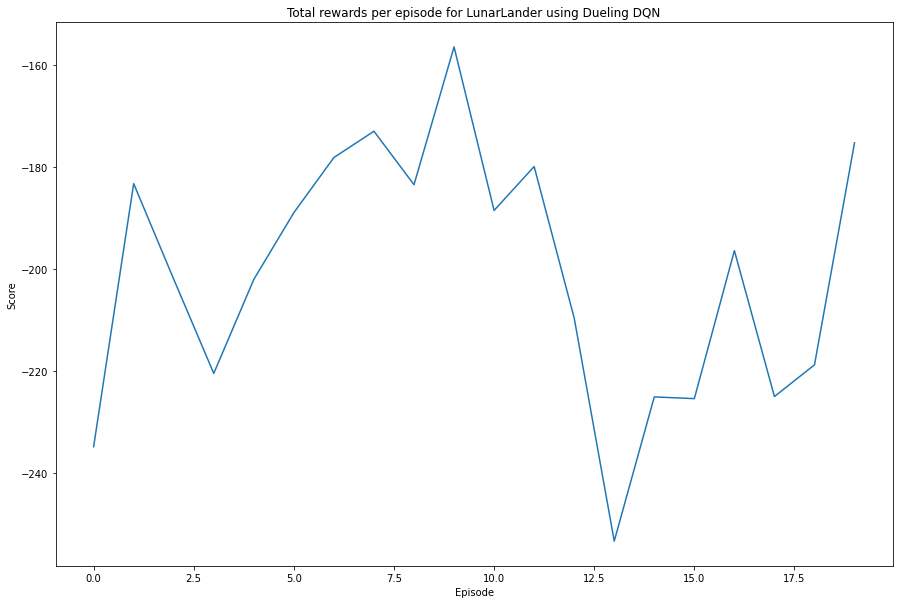

In [ ]:
plot_learning(scores = scores, string = "Total rewards per episode for LunarLander using Dueling DQN")

[0.7943282347242815, 0.6309573444801932, 0.5011872336272722, 0.3981071705534972, 0.3162277660168379, 0.25118864315095796, 0.19952623149688792, 0.15848931924611132, 0.1258925411794167, 0.09999999999999998, 0.07943282347242814, 0.06309573444801932, 0.05011872336272722, 0.03981071705534972, 0.03162277660168379, 0.025118864315095798, 0.019952623149688792, 0.01584893192461113, 0.012589254117941668, 0.009999999999999997]


<Figure size 1080x720 with 0 Axes>

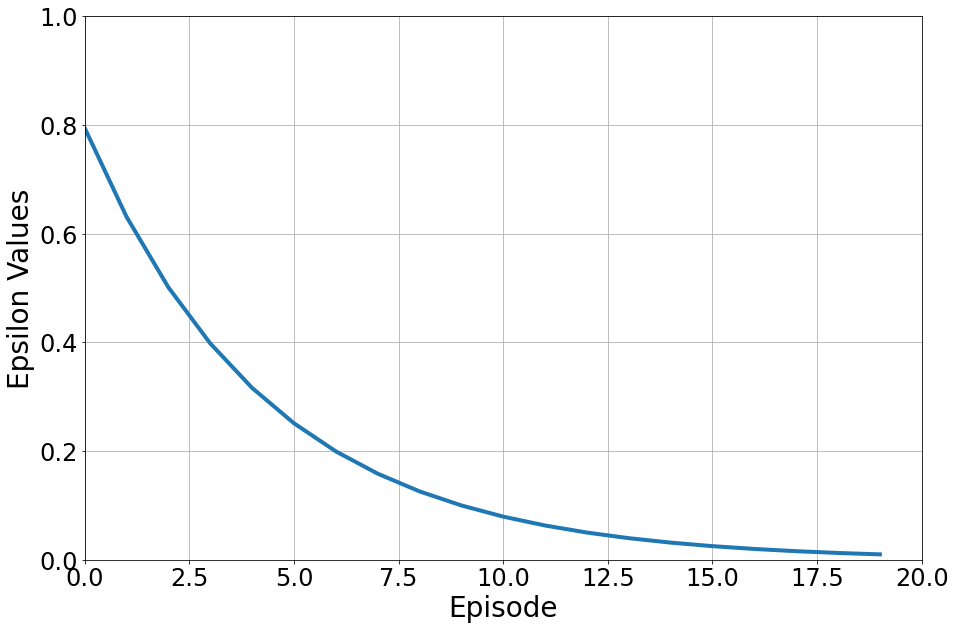

In [ ]:
plot_learning_curves(num_episodes = 20)

In [ ]:
import gym
from gym import spaces

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



STATES = [['MS' , '  ' , '  ' , 'FB' , '  ' ],
          ['  ' , '  ' , '  ' , '  ' , '  ' ],
          ['  ' , '  ' , '  ' , '  ' , '  ' ],
          ['FF' , 'FF' , '  ' , 'CR' , '  ' ],
          ['  ' , '  ' , 'FB' , '  ' , '  ' ],
          ['  ' , '  ' , '  ' , '  ' , '  ' ],
          ['FT' , '  ' , '  ' , '  ' , 'SR' ]]

AUDIO  = [['( 1,  1, -4, -3)' , '( 1,  1, -3, -3)' , '( 1, 1, -2,  1)' , '( 1,  1,  1, 1)' , '(-2,  1,  1, 1)' ],
          ['( 1,  1,  1, -2)' , '( 1,  1,  1, -2)' , '( 1, 1,  1, -4)' , '( 1, -2,  1, 1)' , '( 1,  1,  1, 1)' ],
          ['( 1,  1,  1, -1)' , '( 1,  1,  1, -1)' , '( 1, 1,  1, -3)' , '( 1, -3,  1, 1)' , '( 1,  1,  1, 1)' ],
          ['( 1,  1, -1,  1)' , '(-1,  1,  1,  1)' , '(-1, 1,  1, -2)' , '(-2, -4,  1, 1)' , '(-3,  1,  1, 1)' ],
          ['( 1, -1, -3,  1)' , '( 1, -1, -2,  1)' , '( 1, 1,  1,  1)' , '(-2,  1,  1, 1)' , '(-3,  1,  1, 1)' ],
          ['( 1, -2,  1,  1)' , '( 1, -2,  1,  1)' , '( 1,-2,  1,  1)' , '( 1,  1,  1, 1)' , '( 1,  1,  1, 1)' ],
          ['( 1, -3,  1,  1)' , '( 1, -3,  1,  1)' , '( 1,-3,  1,  1)' , '( 1,  1,  1, 1)' , '( 1,  1,  1, 1)' ]]

AUDIO_INTENSITY = {
    1: 0,
    0: 83,
    -1: 72,
    -2: 60,
    -3: 50,
    -4: 37
    }
ACTIONS = {
        0: ['L',(0,-1)], #Left
        1: ['U',(-1,0)], #Up
        2: ['R', (0,1)],  #Right
        3: ['D',(1,0)]   #Down
    }
REWARDS = {
        'FB' : -2, #Fire Ball
        'FF' : -3, #Fire Flower
        'CR' : 2,  #Coin Reward
        'SR' : 4,  #Star Reward
        'FT' : 10  #Flag Terminal State
    }

# Icons to be used for Visualization
ICONS = {
        '-2' : "./images/fire_ball.png",
        '-3' : "./images/fire_flower.png",
        '2'  : "./images/coin_reward.png",
        '4'  : "./images/star_reward.png",
        '10' : "./images/flag_goal.png",
        "MS" : "./images/mario_agent.png",
        "-3MS" : "./images/fire_flower_mario.png",
        "-2MS" : "./images/fire_ball_mario.png",
        "2MS"  : "./images/coin_reward_mario.png",
        "4MS"  : "./images/star_reward_mario.png",
        "10MS" : "./images/flag_goal_mario.png"

    }

class MyMarioEnvironment(gym.Env):
    def __init__(self, environment:list[list]=STATES, actions:dict=ACTIONS, rewards:dict=REWARDS, p_transition:float=1.0, environment_type:str='deterministic'):
        """This function is used to initialize the Environment Class
        Args:
            environment (list[list], optional): Represents the environment defined with characters. Defaults to STATES.
            actions (dict, optional): Map of actions allowed in the environment. Defaults to ACTIONS.
            rewards (dict, optional): Map of rewards allowed in the environment. Defaults to REWARDS.
            p_transition (float, optional): Probability of transition used for Stochastic Environment. Defaults to None. If value is 1 then acts as Deterministic environment
            epsilon (float, optional): Used to exploration and exploitation policy (Not used for Part1). Defaults to None.
            discount_factor (float, optional): Used to discount the rewards (Not used for Part1). Defaults to None.
            environment_type (str, optional): The type of environment. Takes input 'deterministic' or 'stochastic'. Defaults to None.
        """

        self.environment = environment
        self.env_row, self.env_col = len(self.environment), len(self.environment[0])
        self.states, self.start_pt, self.end_pt, self.current_pt, self.current_state = self._get_state_space(environment, rewards)
        self.observation_space = spaces.Discrete(self.env_row*self.env_col)
        self.action_space = spaces.Discrete(len(actions))
        self.environment_type = environment_type
        self.p_transition = p_transition
        self.observation = self.states.flatten()
        self.rewards = rewards
        self.rewards_space = self._get_reward_space(environment, rewards)
        self.render_help =  self._get_reward_space(environment, rewards)
        self.actions = actions
        self.action_letters = self._get_action_letter_map(actions)
        self.T_M = self._get_transition_matrix()
        self.current_action = -1
        self.current_action_index = -1
        self.reward_states_gained = []

    def step(self, action:str):
        """Step function that perform next action. 
        Args:
            action (str): the action taken at a time step
        Returns:
            observation, reward, done, info: return the observation after action, the reward received, whether max timestep reached and other debug info
        """
        done = False
        info = {}
        if action not in self.action_letters.keys():
            self.new_reward = 0
        else:
            self.current_action = self.action_letters[action]
            t_action = self.T_M[self.current_state][self.current_action]
            t_prob = [t[0] for t in t_action]
            self.current_action_index = np.random.choice(a = len(t_action), p = t_prob)
            prob, new_pt, new_reward, done = t_action[self.current_action_index]
            self.previous_state = self.current_state
            self.current_state = self._get_state_from_xy(*new_pt)
            self.current_pt = new_pt
            self.state = self._get_state_from_xy(*self.current_pt)
            if self.state in self.reward_states_gained:
                self.new_reward = 0
            else:
                self.new_reward = new_reward
                if new_reward > 0:
                    self.reward_states_gained.append(self.state)
            self.states[self.current_pt[0]][self.current_pt[1]] = -5
            self.observation = self._get_audio_observation(*self.current_pt) #self.states.flatten()
            self.reward_states_gained = [] if done else self.reward_states_gained
            info = {'action_performed':self.actions[self.current_action_index][0], 'prob':prob}
        return self.observation, self.new_reward, done, info
        
    def reset(self):
        """Reset's the environment with initial values
        Returns:
            observation: return the observation after reset
        """
        self.timestep = 0
        self.states, self.start_pt, self.end_pt, self.current_pt, self.current_state = self._get_state_space(self.environment, self.rewards)
        self.state = self._get_state_from_xy(*self.current_pt)
        self.observation = self._get_audio_observation(*self.current_pt) #self.states.flatten()
        return self.observation

    def render(self, mode:str="rgb", icons:dict=ICONS):
        """Renders the environment
        Args:
            mode (str, optional): Mode of rendering whether RGB or pictorial. Defaults to "rgb".
            icons (dict, optional): Image locations for pictorial mode. Defaults to ICONS.
        """
        if mode == "rgb":
            plt.imshow(self.states) 
            plt.show()
        elif mode == "human":
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.set_xlim(0, 5)
            ax.set_ylim(0, 7)
            im = plt.imread("./images/bg.jpg")
            im = ax.imshow(im)
            for r in range(self.env_row):
                for c in range(self.env_col):
                    if np.array_equal(self.current_pt,[r,c]) and np.array_equal(self.render_help[r][c],0):
                        img = icons['MS']
                    elif np.array_equal(self.current_pt,[r,c]) and not np.array_equal(self.render_help[r][c],0):
                        img = icons[str(int(self.render_help[r][c]))+"MS"]
                        if self.state in self.reward_states_gained:
                            self.rewards_space[r][c] = 0
                    elif not np.array_equal(self.current_pt,[r,c]) and not np.array_equal(self.rewards_space[r][c],0):
                        img = icons[str(int(self.rewards_space[r][c]))]
                    else:
                        continue

                    agent = AnnotationBbox(OffsetImage(plt.imread(img), zoom=0.5), np.add((c,6-r), [0.5, 0.5]), frameon=False)
                    ax.add_artist(agent)      

            plt.xticks([0, 1, 2, 3, 4])
            plt.yticks([0, 1, 2, 3, 4, 5, 6])
            plt.grid()  
            plt.show()

    def _get_audio_observation(self, current_x, current_y):
        obs = eval(AUDIO[current_x][current_y])
        return (self._get_state_from_xy(current_x, current_y), AUDIO_INTENSITY[obs[0]], AUDIO_INTENSITY[obs[1]], AUDIO_INTENSITY[obs[2]], AUDIO_INTENSITY[obs[3]])

    def _get_action_letter_map(self, actions):
        action_letter = {}
        for a,v in actions.items():
            action_letter[v[0]] = a
        return action_letter

    def _get_state_space(self, environment:list[list]=None, rewards:dict=None):
        state_space = np.zeros((self.env_row,self.env_col))
        for r in range(self.env_row):
            for c in range(self.env_col):
                if environment[r][c] in rewards:
                    state_space[r][c] = rewards[environment[r][c]]
                
                if environment[r][c] == 'MS':
                    state_space[r][c] = -5 #if states is used for rendering
                    start = np.array((r,c))
                elif environment[r][c] == 'FT':
                    end = np.array((r,c))
                
        return state_space, start, end, start, self._get_state_from_xy(*start)
    
    def _get_reward_space(self, environment:list[list]=None, rewards:dict=None):
        rewards_space = np.zeros((self.env_row,self.env_col))
        for r in range(self.env_row):
            for c in range(self.env_col):
                if environment[r][c] in rewards:
                    rewards_space[r][c] = rewards[environment[r][c]]                
        return rewards_space

    def _get_reward(self, state_pt):
        self.new_reward = self.rewards_space[state_pt[0]][state_pt[1]]
        return self.new_reward
    
    def _update_reward(self, action, action_index):
        if self.T_M[self.previous_state][action][action_index][2] > 0:
            self.rewards_space[self.current_pt[0]][self.current_pt[1]] = 0
            self.T_M[self.previous_state][action][action_index][2] = 0

    def _get_next_pt(self, action, pt=None):
        if pt is None:
            pt = self.current_pt
        new_pt = pt + action
        if new_pt[0] < 0 or new_pt[0] == self.env_row or new_pt[1] < 0 or new_pt[1] == self.env_col:
            return pt
        else:
            return new_pt

    def _get_state_from_xy(self, row, col):
        return row*self.env_col + col
    
    def _get_step_transition(self, current_pt, current_action):
        next_pt = self._get_next_pt(action=self.actions[current_action][1], pt = current_pt)
        new_state = self._get_state_from_xy(*next_pt)
        reward = self._get_reward(next_pt)
        done = True if np.array_equal(self.end_pt,next_pt) else False
        return next_pt, reward, done 
    
    def _get_transition_matrix(self):
        T_M = {s: {a: [[] for a in range(self.action_space.n)] for a in range(self.action_space.n)} for s in range(self.observation_space.n)}
        for row in range(self.env_row):
            for col in range(self.env_col):
                s = self._get_state_from_xy(row,col)
                for a in range(self.action_space.n):
                    li = T_M[s][a]
                    if self.environment_type=='stochastic':
                        li[a] = [self.p_transition, *self._get_step_transition(np.array((row,col)),a)]
                        p_tran_others = (1 - self.p_transition)/3
                    else:
                        li[a] = [1.0, *self._get_step_transition(np.array((row,col)),a)]
                        p_tran_others = 0.0
                    
                    for ac in range(self.action_space.n):
                            if ac != a:
                                li[ac] = [p_tran_others, *self._get_step_transition(np.array((row,col)),ac)]
        return T_M

TypeError: ignored

In [ ]:
env = gym.make('LunarLander-v2')

input_dims = env.observation_space.shape[0]
output_dims = env.action_space.n

num_episodes = 20

agent = DuelingDQAgent(discount_factor = 0.99, epsilon = 1.0, learning_rate = 5e-4, input_dims = input_dims, output_dims = output_dims, memory_size = 100, batch_size = 64, epsilon_min = 0.01,  epsilon_decay = 0.995, replace_every = 100)

scores, epsilon_history = [] , []


for i in range(num_episodes):
  done = False
  observation = env.reset()
  score = 0

  while not done:
    action = agent.act(observation)
    next_observation, reward, done, info = env.step(action)
    score  += reward
    agent.store_transitions_for_experience_replay(observation, action, reward, next_observation, int(done))
    agent.train()
    observation = next_observation
    
  scores.append(score)
  average_score = np.mean(scores[-100:])

  print('Episode:', i, 'score %.1f' % score, 'average score %.1f' % average_score, 'epsilon %.2f' % agent.epsilon)


  epsilon_history.append(agent.epsilon)